#ЛУЧШАЯ МОДЕЛЬ - объединяю все знания из спринта 2

In [2]:
# НАСТРАИВАЮ ПОДКЛЮЧЕНИЕ

#моя базовая версия модели
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv()# подгружаем .env
import mlflow
import warnings
warnings.filterwarnings("ignore")

%reload_ext autoreload
import os
import pandas as pd
from sqlalchemy import create_engine

# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

# Создадим соединения
src_conn = create_engine(f'postgresql://{src_username}:{src_password}@{src_host}:{src_port}/{src_db}')
dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')

#ПОДХОД 2 - ОБРАБАТЫВАЮ И УЧИТЫВАЮ ПОЛЯ KITCHEN ARE/LIVING AREA ВМЕСТО TOTAL AREA

In [3]:
# в результате ETL pipeline создана таблица flats_data
#исправляю на запрос

SQL = f"""select b.id, a.build_year, a.building_type_int, a.latitude, a.longitude, 
a.ceiling_height, a.flats_count, a.floors_total, a.has_elevator,
b.floor, b.is_apartment, b.kitchen_area, b.living_area, b.rooms, b.studio, b.total_area, b.price, b.building_id
from buildings as a 
left join flats as b on a.id=b.building_id"""
data_set = pd.read_sql(SQL, dst_conn)
data_set

,id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,building_id
0,0,1965,6,55.717113,37.781120,2.64,84,12,True,9,False,9.90,19.900000,1,False,35.099998,9500000,6220
1,1,2001,2,55.794849,37.608013,3.00,97,10,True,7,False,0.00,16.600000,1,False,43.000000,13500000,18012
2,2,2000,4,55.740040,37.761742,2.70,80,10,True,9,False,9.00,32.000000,2,False,56.000000,13500000,17821
3,3,2002,4,55.672016,37.570877,2.64,771,17,True,1,False,10.10,43.099998,3,False,76.000000,20000000,18579
4,4,1971,1,55.808807,37.707306,2.60,208,9,True,3,False,3.00,14.000000,1,False,24.000000,5200000,9293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141357,141357,2013,4,55.626579,37.313503,2.64,672,25,True,16,False,11.00,18.000000,1,False,42.000000,10500000,22455
141358,141358,1960,1,55.727470,37.768677,2.48,80,5,False,5,False,5.28,28.330000,2,False,41.110001,7400000,3162
141359,141359,1966,4,55.704315,37.506584,2.64,72,9,True,7,False,5.30,20.000000,1,False,31.500000,9700000,6513
141360,141360,2017,4,55.699863,37.939564,2.70,480,25,True,15,False,13.80,33.700001,2,False,65.300003,11750000,23952


In [4]:
#процесс очистки данных!
#1 - цену квартиры - убираем выбросы
#2 - количество комнат - не более 10
#3 - общая площадь не более 500
#4 - потолки - от 2.2 до 5 метров
#5 - в доме не более 2000 квартир
#6 - этажей в доме не более 40

data_set=data_set.query('price<100000000 and price>500000')
data_set=data_set.query('rooms<10')
data_set=data_set.query('total_area<500')
data_set=data_set.query('ceiling_height>=2.2 and ceiling_height<5')
data_set=data_set.query('flats_count<2000')
data_set=data_set.query('floors_total<=40')

In [5]:
#обязательно чистим от неявных дублей!!!!
#дубликаты на основе равенства значений всех признаков

feature_cols_flats=['floor','is_apartment','rooms','total_area','building_id','price']
is_duplicated_features = data_set.duplicated(subset=feature_cols_flats, keep='last')
#print(data_set[is_duplicated_features==True].sort_values(by=['floor','price'],ascending=True))
#print(len(data_set[is_duplicated_features]))

data_set = data_set[~is_duplicated_features].reset_index(drop=True) 

In [6]:
data_set.describe()

,id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area,price,building_id
count,126126.000000,126126.000000,126126.000000,126126.000000,126126.000000,126126.000000,126126.000000,126126.000000,126126.000000,126126.000000,126126.000000,126126.000000,126126.000000,1.261260e+05,126126.000000
mean,72046.998874,1986.046335,3.275716,55.729602,37.589727,2.739782,247.951334,13.801001,7.290725,8.886292,30.242742,2.077700,58.553906,1.517851e+07,13861.849008
std,41006.172216,21.774252,1.461175,0.104041,0.152329,0.192629,187.882320,6.066906,5.282128,4.719720,19.908488,0.920803,27.896234,1.210873e+07,6924.106523
min,0.000000,1901.000000,0.000000,55.211460,36.864372,2.250000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,11.000000,6.000000e+05,1.000000
25%,36639.250000,1969.000000,2.000000,55.652493,37.491108,2.640000,112.000000,9.000000,3.000000,6.200000,19.000000,1.000000,39.000000,8.890000e+06,8443.000000
50%,73151.500000,1984.000000,4.000000,55.721928,37.581676,2.640000,200.000000,14.000000,6.000000,8.700000,29.400000,2.000000,52.000000,1.160000e+07,14051.000000
75%,107517.750000,2006.000000,4.000000,55.809364,37.698715,2.800000,321.000000,17.000000,10.000000,10.100000,40.500000,3.000000,69.000000,1.620000e+07,20173.000000
max,141361.000000,2023.000000,6.000000,56.011032,37.946411,4.600000,1630.000000,40.000000,40.000000,102.000000,300.000000,9.000000,470.000000,9.999999e+07,24620.000000


In [7]:
# Рассчитаем долю жилой площади:
data_set['living_share'] = data_set['living_area']/data_set['total_area']
# Вычислим долю площади кухни:
data_set['kitchen_share'] = data_set['kitchen_area']/data_set['total_area']
#data_set.groupby('rooms').agg({'living_share':'median','kitchen_share':'median', 'id':'count'})
#data_set.query('living_area==0 or kitchen_area==0').groupby('rooms').agg({'living_share':'median','kitchen_share':'median', 'id':'count'})
#вот так прям нормально работает, потом лишнее надо потереть
data_set['median_living']=data_set.groupby('rooms')['living_share'].transform('median')
data_set['median_kitchen']=data_set.groupby('rooms')['kitchen_share'].transform('median')
#пробую на отдельном поле
data_set['living_area_test']=data_set['living_area']
data_set['kitchen_area_test']=data_set['kitchen_area']
#data_set.query('living_area_test==0').head(10)
data_set.loc[data_set['living_area'] == 0,'living_area'] = data_set['median_living']*data_set['total_area']
data_set.loc[data_set['kitchen_area'] == 0,'kitchen_area'] = data_set['median_kitchen']*data_set['total_area']

In [7]:
#проверяю что получилось
#data_set.query('living_area_test==0')[['rooms','living_area','living_area_test']]
#data_set.query('kitchen_area_test==0')[['rooms','kitchen_area','kitchen_area_test']]
#data_set.query('kitchen_area_test==0')[['rooms','kitchen_area','kitchen_area_test']]

In [8]:
#теперь удаляю из датасета лишние поля
data_set=data_set.drop(columns=['median_living', 'median_kitchen', 'living_area_test','kitchen_area_test', 'living_share','kitchen_share'])

In [9]:
#теперь удаляю где есть пропуски
data_set=data_set.query('living_area!=0 and kitchen_area!=0')

In [10]:
# тут пустых нет
data_set[data_set['price'].isna()==True]

,id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,building_id


#ЧАСТЬ 3 поля/TYPE/LATITUDE/LONGITUDE
#ПРОГОНЯЮ И СМОТРЮ НА РЕЗУЛЬТАТ

In [11]:
#разделим опять признаки

#бинарные - has_elevator, is_apartment
binary_cat_features=data_set[['has_elevator', 'is_apartment']]
num_features=data_set[['build_year', 'ceiling_height', 'floors_total', 'floor', 'rooms', 'total_area','flats_count','kitchen_area','living_area']] 
target=data_set['price']
territory_features=data_set[['latitude','longitude']]
poly_features=data_set[['ceiling_height', 'floors_total', 'floor', 'rooms', 
                        'total_area','flats_count', 'kitchen_area', 'living_area']]


In [12]:
#Объединяем трансформации

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures

binary_cols = binary_cat_features.columns.tolist()
num_cols = num_features.columns.tolist()
poly_cols = poly_features.columns.tolist()
territory_cols=territory_features.columns.tolist()

# определите список трансформаций в рамках ColumnTransformer
preprocessor = ColumnTransformer(
[
    ('binary',OneHotEncoder(drop='if_binary'),binary_cols),
    ('num',StandardScaler(),num_cols),
    ('geo',KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform'),territory_cols),
  ('pol',PolynomialFeatures(degree=2, include_bias=False),poly_cols)
],verbose_feature_names_out=True,
remainder='passthrough'#'drop'
)

# трансформируйте исходные данные data с помощью созданного preprocessor
data_transformed = preprocessor.fit_transform(data_set.drop(columns=['price']),data_set['price'])

data_transformed=pd.DataFrame(data_transformed, columns=preprocessor.get_feature_names_out())

data_transformed.head(2).T

,0,1
binary__has_elevator_True,1.0,1.0
binary__is_apartment_True,0.0,0.0
num__build_year,-0.966574,0.686762
num__ceiling_height,-0.518002,1.350878
num__floors_total,-0.296858,-0.626516
...,...,...
pol__living_area^2,396.009985,275.560013
remainder__id,0,1
remainder__building_type_int,6,2
remainder__studio,False,False


In [13]:
data_transformed['price']=data_set['price']

In [14]:
#y_train
data_transformed.head(1).T

columns_X=[]
aaa=data_transformed.columns
for i in range(len(aaa)):
    columns_X.append(aaa[i])
columns_X[40:60]

['pol__floor kitchen_area',
 'pol__floor living_area',
 'pol__rooms^2',
 'pol__rooms total_area',
 'pol__rooms flats_count',
 'pol__rooms kitchen_area',
 'pol__rooms living_area',
 'pol__total_area^2',
 'pol__total_area flats_count',
 'pol__total_area kitchen_area',
 'pol__total_area living_area',
 'pol__flats_count^2',
 'pol__flats_count kitchen_area',
 'pol__flats_count living_area',
 'pol__kitchen_area^2',
 'pol__kitchen_area living_area',
 'pol__living_area^2',
 'remainder__id',
 'remainder__building_type_int',
 'remainder__studio']

In [ ]:
['binary__has_elevator_True',
 'binary__is_apartment_True',
 'num__build_year',
 'num__ceiling_height',
 'num__floors_total',
 'num__floor',
 'num__rooms',
 'num__total_area',
 'num__flats_count',
 'num__kitchen_area',
 'num__living_area',
 'geo__latitude',
 'geo__longitude',
 'pol__ceiling_height',
 'pol__floors_total',
 'pol__floor',
 'pol__rooms',
 'pol__total_area',
 'pol__flats_count',
 'pol__kitchen_area']
['pol__living_area',
 'pol__ceiling_height^2',
 'pol__ceiling_height floors_total',
 'pol__ceiling_height floor',
 'pol__ceiling_height rooms',
 'pol__ceiling_height total_area',
 'pol__ceiling_height flats_count',
 'pol__ceiling_height kitchen_area',
 'pol__ceiling_height living_area',
 'pol__floors_total^2',
 'pol__floors_total floor',
 'pol__floors_total rooms',
 'pol__floors_total total_area',
 'pol__floors_total flats_count',
 'pol__floors_total kitchen_area',
 'pol__floors_total living_area',
 'pol__floor^2',
 'pol__floor rooms',
 'pol__floor total_area',
 'pol__floor flats_count']
['pol__floor kitchen_area',
 'pol__floor living_area',
 'pol__rooms^2',
 'pol__rooms total_area',
 'pol__rooms flats_count',
 'pol__rooms kitchen_area',
 'pol__rooms living_area',
 'pol__total_area^2',
 'pol__total_area flats_count',
 'pol__total_area kitchen_area',
 'pol__total_area living_area',
 'pol__flats_count^2',
 'pol__flats_count kitchen_area',
 'pol__flats_count living_area',
 'pol__kitchen_area^2',
 'pol__kitchen_area living_area',
 'pol__living_area^2',
 'remainder__id',
 'remainder__building_type_int',
 'remainder__studio']

In [15]:
data_transformed_poly=data_transformed[['pol__ceiling_height',
 'pol__floors_total','pol__floor','pol__rooms',
 'pol__total_area','pol__flats_count',
 'pol__kitchen_area','pol__living_area','pol__ceiling_height^2',
 'pol__ceiling_height floors_total',
 'pol__ceiling_height floor','pol__ceiling_height rooms',
 'pol__ceiling_height total_area','pol__ceiling_height flats_count',
 'pol__ceiling_height kitchen_area','pol__ceiling_height living_area',
 'pol__floors_total^2','pol__floors_total floor',
 'pol__floors_total rooms','pol__floors_total total_area',
 'pol__floors_total flats_count','pol__floors_total kitchen_area',
 'pol__floors_total living_area','pol__floor^2',
 'pol__floor rooms','pol__floor total_area','pol__floor flats_count',
'pol__floor kitchen_area','pol__floor living_area',
 'pol__rooms^2','pol__rooms total_area','pol__rooms flats_count',
 'pol__rooms kitchen_area','pol__rooms living_area',
 'pol__total_area^2','pol__total_area flats_count',
 'pol__total_area kitchen_area','pol__total_area living_area',
 'pol__flats_count^2','pol__flats_count kitchen_area',
 'pol__flats_count living_area','pol__kitchen_area^2',
 'pol__kitchen_area living_area',
 'pol__living_area^2','price']]

In [16]:
x=data_transformed_poly.drop(columns=['price'])
y=data_set['price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2) 

In [17]:
#учу модель на отобранных признаках

from sklearn.linear_model import Ridge
model=Ridge()
model_pol=model.fit(X_train,y_train)
y_pred_pol=model.predict(X_test)

from sklearn.metrics import r2_score
r2_score(y_test,y_pred_pol)

0.702372627317577

In [ ]:
#отбор не делаю, чуть лучше чем было в спринте 1

#ОТБОР ПАРАМЕТРОВ

In [27]:
X_train[columns_X[20:40]]

,pol__living_area,pol__ceiling_height^2,pol__ceiling_height floors_total,pol__ceiling_height floor,pol__ceiling_height rooms,pol__ceiling_height total_area,pol__ceiling_height flats_count,pol__ceiling_height kitchen_area,pol__ceiling_height living_area,pol__floors_total^2,pol__floors_total floor,pol__floors_total rooms,pol__floors_total total_area,pol__floors_total flats_count,pol__floors_total kitchen_area,pol__floors_total living_area,pol__floor^2,pol__floor rooms,pol__floor total_area,pol__floor flats_count
64817,20.1,6.969601,13.200001,7.92,2.64,84.480003,261.36001,13.728,53.064003,25.0,15.0,5.0,160.0,495.0,25.999999,100.500002,9.0,3.0,96.0,297.0
41251,29.4,6.969601,13.200001,5.28,5.28,118.536009,211.200008,15.312001,77.616002,25.0,10.0,10.0,224.500008,400.0,29.000001,146.999998,4.0,4.0,89.800003,160.0
101434,83.219178,9.0,69.0,63.0,9.0,405.0,780.0,60.0,249.657534,529.0,483.0,69.0,3105.0,5980.0,460.0,1914.041096,441.0,63.0,2835.0,5460.0
74127,19.0,7.29,32.400001,10.8,5.4,86.13,866.700015,27.0,51.300001,144.0,48.0,24.0,382.799995,3852.0,120.0,228.0,16.0,8.0,127.599998,1284.0
102911,20.0,6.969601,31.680001,5.28,2.64,92.928006,221.760009,25.080001,52.800002,144.0,24.0,12.0,422.400009,1008.0,114.0,240.0,4.0,2.0,70.400002,168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36888,21.700001,6.969601,23.760001,5.28,2.64,84.216002,187.440007,13.728,57.288004,81.0,18.0,9.0,287.099997,639.0,46.799998,195.300007,4.0,2.0,63.799999,142.0
32023,40.0,9.0,42.0,36.0,9.0,210.0,189.0,81.0,120.0,196.0,168.0,42.0,980.0,882.0,378.0,560.0,144.0,36.0,840.0,756.0
72665,56.5,7.29,37.800001,10.8,10.8,227.610012,680.400012,22.95,152.550003,196.0,56.0,56.0,1180.200043,3528.0,119.0,791.0,16.0,16.0,337.200012,1008.0
45262,20.0,6.969601,44.880002,21.120001,2.64,100.320004,768.240031,26.400001,52.800002,289.0,136.0,17.0,646.0,4947.0,170.0,340.0,64.0,8.0,304.0,2328.0


In [1]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import Ridge
model=Ridge()
sbs1 = SFS(model, k_features=10,#7,#10, 
           forward=True, floating=False, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

sbs1 = sbs1.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [32]:
import numpy as np
# Выбор признаков с помощью SBS
selected_feature_indices = sbs1.k_feature_idx_
#top_sfs=np.array(df)[list(selected_feature_indices)]
top_sfs=sbs1.k_feature_names_
top_sfs

('build_year',
 'ceiling_height',
 'floors_total',
 'floor',
 'rooms',
 'total_area',
 'flats_count',
 'kitchen_area',
 'living_area',
 'rayon')

In [33]:
#тут нужен ЦИКЛ с перебором значений
feature_otbor=[]

for i in range(len(top_sfs)):
    feature_otbor.append(top_sfs[i])
feature_otbor

['build_year',
 'ceiling_height',
 'floors_total',
 'floor',
 'rooms',
 'total_area',
 'flats_count',
 'kitchen_area',
 'living_area',
 'rayon']

In [34]:
#в обратную сторону

sbs2 = SFS(model, k_features=10, 
           forward=False, floating=True, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
sbs2 = sbs2.fit(X_train, y_train)


In [35]:
# Выбор признаков с помощью SBS
selected_feature_indices2 = sbs2.k_feature_idx_
#top_sbs=np.array(df)[list(selected_feature_indices2)]
top_sbs=sbs2.k_feature_names_
top_sbs

('build_year',
 'ceiling_height',
 'floors_total',
 'floor',
 'rooms',
 'total_area',
 'flats_count',
 'kitchen_area',
 'living_area',
 'rayon')

In [36]:
X_train_selected = X_train[feature_otbor]
X_test_selected = X_test[feature_otbor]

X_train_selected


,build_year,ceiling_height,floors_total,floor,rooms,total_area,flats_count,kitchen_area,living_area,rayon
67155,-0.369536,-0.518002,-0.791346,-0.05504,1.00163,-0.306634,0.585734,-0.877588,-0.027608,0
125641,-1.196204,1.350878,-1.450663,-0.433676,-0.084383,-0.127398,-0.851341,-0.272777,-0.065632,0
60093,-1.333981,1.350878,-1.450663,-0.433676,1.00163,0.15938,-1.085531,-0.393739,0.064736,0
17067,0.457132,-0.518002,0.527289,-1.19095,-0.084383,-0.052119,-0.606506,0.211072,-0.130815,0
4325,-0.32361,-1.348616,-0.296858,-0.622995,-0.084383,-0.231355,-0.446831,0.09011,-0.185135,0
...,...,...,...,...,...,...,...,...,...,...
84649,1.467504,0.312611,1.845924,0.891552,-0.084383,-0.001932,4.976798,-0.013258,-0.174271,0
13371,0.13565,-0.518002,0.527289,-0.244358,-0.084383,-0.270787,0.372834,-0.296969,-0.244887,0
101288,-1.379907,1.350878,-1.450663,-0.812313,1.00163,0.15938,-1.053596,-0.272777,0.282015,0
4645,1.146022,-0.206522,1.186606,0.512916,-1.170397,-0.521718,0.718797,0.09011,-0.695741,0


In [37]:
#учу модель на отобранных признаках

from sklearn.linear_model import Ridge
model=Ridge()
model_otbor=model.fit(X_train_selected,y_train)
y_pred_otbor=model.predict(X_test_selected)

from sklearn.metrics import r2_score
r2_score(y_test,y_pred_otbor)

0.7121152426371147

In [38]:
#учу модель на всех признаках

from sklearn.linear_model import Ridge
model=Ridge()
model_=model.fit(X_train,y_train)
y_pred_=model.predict(X_test)

from sklearn.metrics import r2_score
r2_score(y_test,y_pred_)

0.7121603292639815

In [39]:
df_res=pd.DataFrame(y_test/1000) 

df_res['y_pred_otbor']=y_pred_otbor/1000
df_res

,price,y_pred_otbor
42070,9900.0,7787.340338
15280,12500.0,10423.642602
63786,29250.0,24323.367223
35808,11300.0,7155.502364
110226,7000.0,8172.132336
...,...,...
56588,12200.0,8855.637195
124306,8450.0,9516.382041
82049,12700.0,10552.954602
21939,12300.0,9571.094579


In [59]:
#пузырьковая диаграмма

import plotly.express as px
import matplotlib.pyplot as plt

#px.figure(figsize=(5,5))
fig=px.scatter(df_res,x='price',y='y_pred_otbor',opacity=0.6)
fig

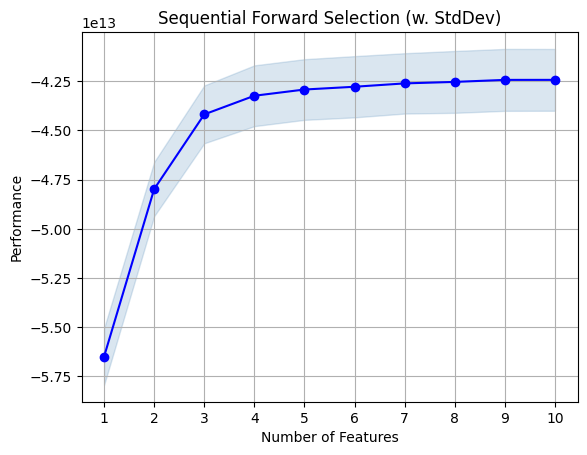

In [40]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs1.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

#plt.savefig("fs_assets/sfs.png")

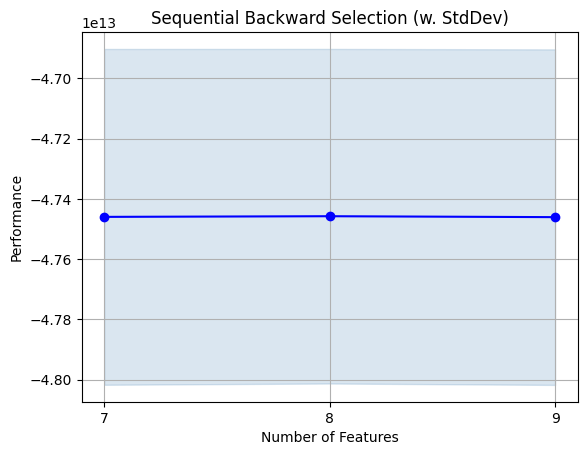

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs2.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

#plt.savefig("fs_assets/sbs.png")

#ЧАСТЬ - ПОДБОР ОПТИМАЛЬНОГО ГИПЕРПАРАМЕТРА

In [50]:
#вот отсюда будет отличие для OPTUNA
##MLFLOW info

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "sprint_2_project"
RUN_NAME = "sprint_2_project_run"
REGISTRY_MODEL_NAME ="model"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "STUDY_OPTUNA_2"

In [51]:
import optuna
from collections import defaultdict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import array
import joblib

# Определение функции для Optuna
def objective(trial: optuna.Trial) -> float:
    param = {
        'alpha': trial.suggest_float("alpha",0.001, 300)}
    model=Ridge(**param)
    model.fit(X_train_selected,y_train)
    y_pred=model.predict(X_test_selected)

    #вычисление метрик
    r2=r2_score(y_test,y_pred)

    #mse = cross_val_score(model,x,y,scoring='neg_mean_squared_error',cv=10)
    return r2


In [52]:
from optuna.integration.mlflow import MLflowCallback

import warnings
warnings.filterwarnings("ignore")

In [53]:
# Настройка эксперимента в MLflow
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

if mlflow.active_run():
    print(f"Active run exists: {mlflow.active_run().info.run_id}")
    mlflow.end_run()  # Завершить текущий run

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id, nested=True) as run:
    run_id = run.info.run_id
    
    #mlflow.catboost.log_model(model,'model_pkl')

# Callback для Optuna
    mlflc = MLflowCallback(
        tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
        metric_name="AUC",
        create_experiment=False,
        mlflow_kwargs={'experiment_id': experiment_id, 'nested': True,'tags': {'mlflow.parentRunId': run_id}})

# Запуск Optuna с использованием функции objective
    study = optuna.create_study(
        sampler=optuna.samplers.TPESampler(),
        direction='maximize',
        study_name=STUDY_NAME,
        storage=STUDY_DB_NAME,
        load_if_exists=True)
    study.optimize(objective, n_trials=10, callbacks=[mlflc])

#ЛУЧШАЯ МОДЕЛЬ

    best_params = study.best_params
#print(f"Число завершенных испытаний: {len(study.trials)}")
#print(f"Лучшие параметры: {best_params}")

    model=Ridge(**best_params)
    model.fit(X_train_selected,y_train)

#сохраняем модель

    joblib.dump(model,'model.pkl')
# логируем в MLFLOW

    mlflow.sklearn.log_model(model,"cv")
    mlflow.log_artifact('model.pkl',artifact_path='cv')

[I 2024-12-05 16:51:23,568] A new study created in RDB with name: STUDY_OPTUNA_2
[I 2024-12-05 16:51:24,073] Trial 0 finished with value: 0.7120144062541554 and parameters: {'alpha': 260.72313573085313}. Best is trial 0 with value: 0.7120144062541554.
[I 2024-12-05 16:51:24,654] Trial 1 finished with value: 0.7121150656841215 and parameters: {'alpha': 0.32566537108325616}. Best is trial 1 with value: 0.7121150656841215.
[I 2024-12-05 16:51:25,233] Trial 2 finished with value: 0.7120543035505335 and parameters: {'alpha': 214.77405736200973}. Best is trial 1 with value: 0.7121150656841215.
[I 2024-12-05 16:51:25,817] Trial 3 finished with value: 0.7120485089307996 and parameters: {'alpha': 222.10142452184883}. Best is trial 1 with value: 0.7121150656841215.
[I 2024-12-05 16:51:26,448] Trial 4 finished with value: 0.7119889239811 and parameters: {'alpha': 286.03292074443715}. Best is trial 1 with value: 0.7121150656841215.
[I 2024-12-05 16:51:27,126] Trial 5 finished with value: 0.7120576